CLUSTERING AND DRAW RESULTS

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
# from sklearn.metrics import silhouette_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.ensemble import RandomForestRegressor
from scipy.interpolate import make_interp_spline
import os
import sys
sys.path.append('../SKM-master')
from skm import skm

In [2]:
# read to csv files

imputed_file = '../../data_preparation/biomarkers_acute_sample_462/master_acute_sample_462_X7_helsinki.xlsx'
cluster_path = '../../results_462_5-5_helsinki/cluster/'
algorithms = ['kmeans', 'spectral', 'gaussian_mixture', 'agglomerative', 'skm']

biomarkers = ['GFAP', 'NFL', 'Tau', 'UCH-L1', 'S100B', 'NSE']
thresh = {
    'GFAP' : 200, 'NFL' : 2000, 'Tau' : 150, 'UCH-L1' : 4200, 'S100B' : 10, 'NSE' : 175
}
units = {
    'GFAP' : 'ng/ ml', 'NFL' : 'pg/ ml', 'Tau' : 'pg/ ml', 'UCH-L1' : 'pg/ ml', 'S100B' : 'ng/ ml', 'NSE' : 'ng/ ml'
}

df = {}
dfo = {}
for biomarker in biomarkers:
    df[biomarker] = pd.read_excel(imputed_file, sheet_name=biomarker + ' KNN imputed normalized', header = 0, index_col=0)
    df[biomarker] = df[biomarker].apply(pd.to_numeric, errors='coerce')
    dfo[biomarker] = pd.read_excel(imputed_file, sheet_name=biomarker, header = 0, index_col=0)
    # create directory structures to store cluster results as well as plots
    for alg in algorithms:
        os.makedirs(cluster_path + biomarker + '/' + alg + '_plots', exist_ok=True)

print(df.keys())

dict_keys(['GFAP', 'NFL', 'Tau', 'UCH-L1', 'S100B', 'NSE'])


DATA VISUALIZATION

In [3]:
import math
for biomarker in biomarkers:
    # ds = df[biomarker].stack()
    # ds.replace(0, np.nan, inplace=True)
    # ds.hist(bins=200, figsize=[4,4])
    # plt.title(biomarker)
    # plt.show()
    # dslog = np.log(ds)
    # dslog.hist(bins=200, figsize=[4,4])
    # plt.title(biomarker + ' log')
    # plt.show()
    #---------------------------------------------
    break
    ds1 = dfo[biomarker].iloc[:, -5:]
    ds = ds1[(ds1 <= thresh[biomarker]).all(axis=1)]
    x_labels = ['d1', 'd2', 'd3', 'd4', 'd5']
    x = np.array(range(1,6))
    xnew = np.linspace(x.min(), x.max(), 300)
    plt.xticks(x, x_labels)
    y = ds.median()
    y1 = ds.quantile(0.25)
    y2 = ds.quantile(0.75)
    sp = make_interp_spline(x, y)
    sp1 = make_interp_spline(x, y1)
    sp2 = make_interp_spline(x, y2)
    ps = sp(xnew)
    ps1 = sp1(xnew)
    ps2 = sp2(xnew)
    plt.plot(xnew, ps, linewidth=1)
    plt.plot(xnew, ps1, linewidth=0.5)
    plt.plot(xnew, ps2, linewidth=0.5)
    #--------------------------------------------
    # for i in ds.index:
    #     x = np.array(range(1,6))
    #     y = ds.loc[i]

    #     xnew = np.linspace(x.min(), x.max(), 300)
    #     spline = make_interp_spline(x, y)
    #     power_smooth = spline(xnew)
    #     plt.xticks(x, x_labels)
    #     plt.plot(xnew, power_smooth, linewidth=1)
        # plt.plot(x,y)
    plt.title(biomarker)
    # plt.gcf().set_size_inches(6, 6)
    plt.show()
    plt.close()


    

    

CLUSTERING

In [4]:
colors = ['green', 'purple', 'blue', 'orange', 'red', 'yellow']
x_labels = ['d1', 'd2', 'd3', 'd4', 'd5']
def plots(label, biomarker, alg, orig=True):
    fig_path = cluster_path + biomarker + '/' + alg + '_plots/'
    n_clusters = label.nunique()
    if orig:
        df_eval = dfo[biomarker].iloc[:, -5:].groupby(label)
        fig_name = 'traj462_' + biomarker + '_' + alg + '_k' + str(n_clusters) + '_orig.png'
    else:
        df_eval = df[biomarker].groupby(label)
        fig_name = 'traj462_' + biomarker + '_' + alg + '_k' + str(n_clusters) + '_imputed.png'
    color = 0
    for name, group in df_eval:
        x = np.array(range(1,group.shape[1] + 1))
        y = group.median(axis=0)
        # ystd = group.std(axis=0)
        # ymin = group.min(axis=0)
        # ymax = group.max(axis=0)
        if pd.isna(y).any():
            print(biomarker, ' ', alg, ' ', n_clusters, ' cluster# : ', name, ' has NaN and cannot plot')
            continue
        xnew = np.linspace(x.min(), x.max(), 300)
        y1 = group.quantile(0.25)
        y2 = group.quantile(0.75)
        sp1 = make_interp_spline(x, y1)
        sp2 = make_interp_spline(x, y2)
        ps1 = sp1(xnew)
        ps2 = sp2(xnew)
        plt.plot(xnew, ps1, color=colors[color], linewidth=0.5, linestyle='--')
        plt.plot(xnew, ps2, color=colors[color], linewidth=0.5, linestyle='--')

        spline = make_interp_spline(x, y)
        # spmin  = make_interp_spline(x, ymin)
        # spmax  = make_interp_spline(x, ymax)
        power_smooth = spline(xnew)
        # ps_min = spmin(xnew)
        # ps_max = spmax(xnew)
        plt.xticks(x, x_labels)
        plt.scatter(x,y,marker='o', label=f'Cluster {name} - {group.shape[0]}', c=colors[color])
        # plt.plot(xnew, power_smooth)
        plt.plot(xnew, power_smooth, color=colors[color], linewidth=0.5, linestyle='-')
        # plt.plot(xnew, ps_min, color=colors[color], linewidth=1)
        # plt.plot(xnew, ps_max, color=colors[color], linewidth=1)
        color += 1
    plt.legend()
    plt.title(biomarker + ' ' + alg + ' k' + str(n_clusters))
    plt.ylabel(units[biomarker], fontsize=12)
    # Uncomment below to write to file - check file name
    # plt.savefig( fig_path + fig_name)
    plt.show()
    plt.close()
    return


In [5]:
def analysis(label, biomarker, alg):
    n_clusters = label.nunique()
    df_eval = dfo[biomarker].groupby(label)
    print(biomarker)
    for name, group in df_eval:
        res = {}
        for i, col in enumerate(group.columns):
            if i > 6:
                break
            if i < 2:
                continue
            res['mean ' + col] = "{:.2f}".format(group[col].mean())
            res['median ' + col] = "{:.2f}".format(group[col].median())
        print(group.columns)
        group['GCS'].hist(bins=7, figsize=[4,4])
        plt.ylim(0,100)
        plt.title(biomarker + ' k'+str(n_clusters) + ' cluster ' + str(name) )
        plt.show()
        print(name, res)


KMEANS

In [6]:
def kmeans(df_in, n_clusters, biomarker):
    # X = df_in.iloc[:, 2:]
    df1 = df_in.copy()
    kmeans = KMeans(n_clusters=n_clusters, random_state= 85)
    kmeans.fit(df1)
    df1["Cluster"] = kmeans.labels_ + 1
    print(biomarker + ' KMeans', df1["Cluster"].value_counts())
    df1['Cluster'].to_csv(cluster_path + biomarker + '/' + biomarker + '_kmeans_k' + str(n_clusters) + '.csv', header = True, index = False)
    return df1['Cluster']


SPECTRAL

In [7]:
def spectral(df_in, n_clusters, affinity, biomarker):
    df1 = df_in.copy()
    spectral = SpectralClustering(n_clusters=n_clusters, affinity=affinity, random_state= 85)
    spectral.fit(df1)
    df1["Cluster"] = spectral.labels_ + 1
    print(biomarker + ' Spectral', df1["Cluster"].value_counts())
    df1['Cluster'].to_csv(cluster_path + biomarker + '/' + biomarker + '_spectral_k' + str(n_clusters) + '.csv', header = True, index = False)
    return df1['Cluster']

GAUSSIAN MIXTURE

In [8]:
def gaussianmix(df_in, n_clusters, biomarker):
    df1 = df_in.copy()
    gmm = GaussianMixture(n_components=n_clusters, random_state= 85)
    gmm.fit(df1)
    df1["Cluster"] = gmm.predict(df1) + 1
    print(biomarker + ' Gaussian Mixture ', df1["Cluster"].value_counts())
    df1['Cluster'].to_csv(cluster_path + biomarker + '/' + biomarker + '_gaussian_mixture_k' + str(n_clusters) + '.csv', header = True, index = False)
    return df1['Cluster']

AGGLOMERATIVE 

In [9]:
def agglomerative(df_in, n_clusters, biomarker):
    # X = df_in.iloc[:, 2:]
    df1 = df_in.copy()
    aggl = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    aggl.fit(df1)
    df1["Cluster"] = aggl.labels_ + 1
    print(biomarker + ' Agglomerative', df1["Cluster"].value_counts())
    df1['Cluster'].to_csv(cluster_path + biomarker + '/' + biomarker + '_agglomerative_k' + str(n_clusters) + '.csv', header = True, index = False)
    return df1['Cluster']


SKM

In [10]:

def skmcluster(df_in, n_clusters, biomarker):
    df1 = (df_in * 100).round()
    seq = df1.values.tolist()
    skmRes = skm(seq, k=n_clusters, maximum_iterations=100, verbose=True)
    df1['Cluster'] = [int(x) + 1 for x in skmRes]
    print(biomarker + ' SKM', df1['Cluster'].value_counts())
    df1['Cluster'].to_csv(cluster_path + biomarker + '/' + biomarker + '_skm_k' + str(n_clusters) + '.csv', header = True, index = False)
    return df1['Cluster']

DBSCAN

In [46]:
def dbscan(df_in, biomarker):
    df1 = df_in.copy()
    print(biomarker)
    for col in df1.columns:
        print(col, df1[col].mean())
    dbs = DBSCAN(eps= 0.13, min_samples=5)
    dbs.fit(df1)
    df1['Cluster'] = dbs.labels_ + 1
    print(biomarker + ' DBSCAN', df1["Cluster"].value_counts())
    
    return df1['Cluster']


MAIN LOOP

GFAP
GFAP_1 0.6240011896004032
GFAP_2 0.6664863182486284
GFAP_3 0.6367834137834608
GFAP_4 0.520705644251757
GFAP_5 0.5548330209388765
GFAP DBSCAN Cluster
1    309
0     64
Name: count, dtype: int64


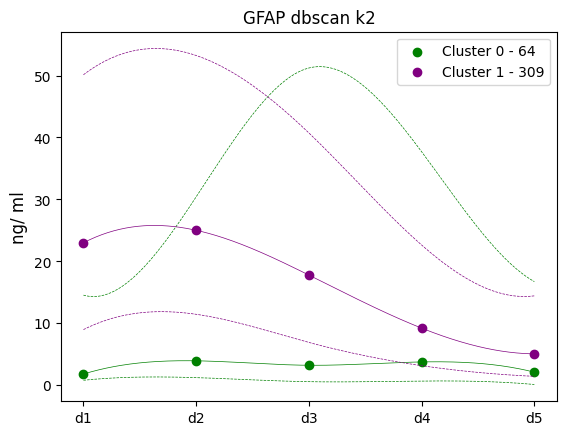

NFL
NFL_1 0.4757739582791554
NFL_2 0.38909176123880745
NFL_3 0.37772390509967335
NFL_4 0.3835517694524845
NFL_5 0.3727125054813714
NFL DBSCAN Cluster
1    340
0     33
Name: count, dtype: int64


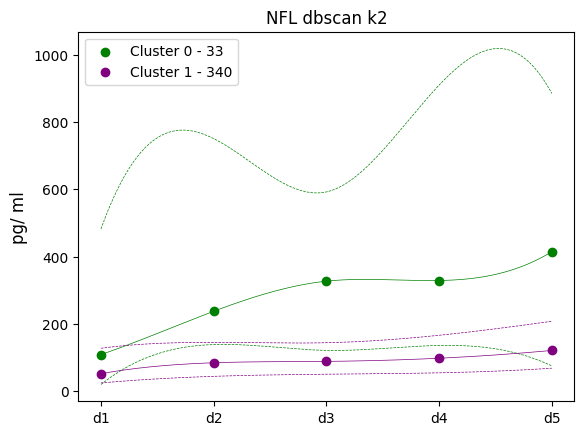

Tau
Tau_1 0.5117958436507708
Tau_2 0.46303838254929913
Tau_3 0.3950833045635281
Tau_4 0.36513505428075677
Tau_5 0.3842936235397534
Tau DBSCAN Cluster
1    266
0    101
2      6
Name: count, dtype: int64


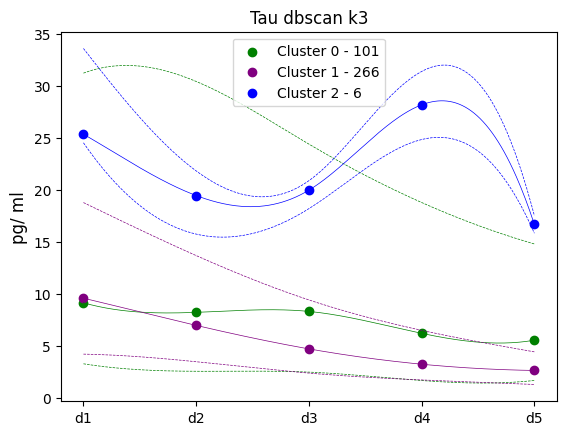

UCH-L1
UCH-L1_1 0.5872230530525513
UCH-L1_2 0.573219506755396
UCH-L1_3 0.6362530608672203
UCH-L1_4 0.7538091373099385
UCH-L1_5 0.5445162887238296
UCH-L1 DBSCAN Cluster
1    314
0     59
Name: count, dtype: int64


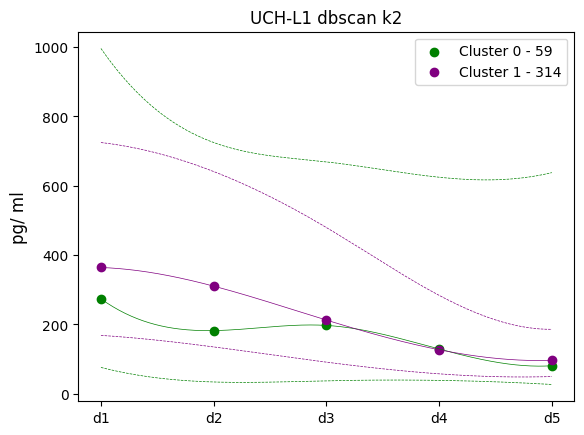

S100B
S100B_1 0.587122821952193
S100B_2 0.4528735022487114
S100B_3 0.4958675877735545
S100B_4 0.3456638263311667
S100B_5 0.3611399722023492
S100B DBSCAN Cluster
1    308
0     65
Name: count, dtype: int64


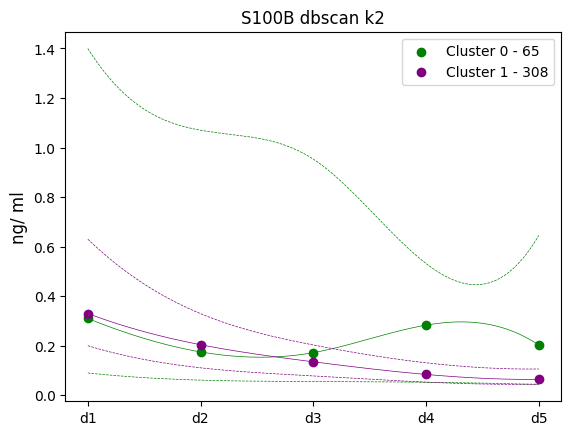

NSE
NSE_1 0.5412414333816132
NSE_2 0.46765575040011953
NSE_3 0.399659683433513
NSE_4 0.3012957336065368
NSE_5 0.3505111771660635
NSE DBSCAN Cluster
1    305
0     68
Name: count, dtype: int64


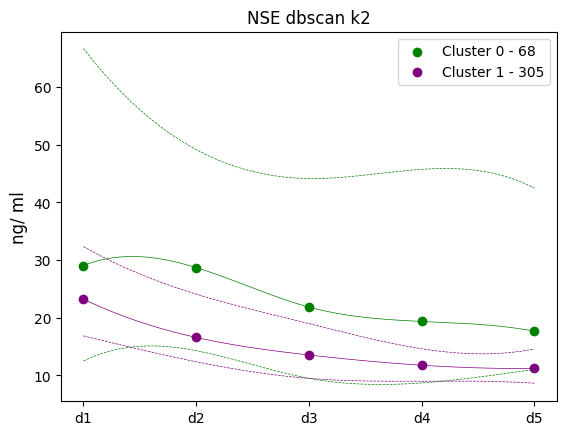

In [47]:
for biomarker in biomarkers:
    # df[biomarker] = pd.read_csv(csv_path + biomarker + '_imputed.csv', header=0)
    #df[biomarker].drop(df[biomarker].columns[[-2,-1]], axis=1, inplace=True)
    df_cluster = {}
    num_clusters = 3 # 6
    plot_orig_data = True
    X = df[biomarker].iloc[:, -5:]
    # for k in range(2,num_clusters):
    #     result = biomarker + '_dbscan_k' + str(k)
    #     df_cluster[result] = pd.Series(dbscan(df_in=X, biomarker=biomarker))
    #     plots(label=df_cluster[result], biomarker=biomarker, alg='dbscan', orig=plot_orig_data)
    #     # analysis(label=df_cluster[result], biomarker=biomarker, alg='agglomerative')
    # continue

    for k in range(2,num_clusters):
        result = biomarker + '_smk_k' + str(k)
        df_cluster[result] = pd.Series(skmcluster(df_in=X, n_clusters=k, biomarker=biomarker))
        plots(label=df_cluster[result], biomarker=biomarker, alg='skm', orig=plot_orig_data)
        # analysis(label=df_cluster[result], biomarker=biomarker, alg='agglomerative')
    # continue
    for k in range(2,num_clusters):
        result = biomarker + '_agglomerative_k' + str(k)
        df_cluster[result] = agglomerative(df_in=X, n_clusters=k, biomarker=biomarker)
        plots(label=df_cluster[result], biomarker=biomarker, alg='agglomerative', orig=plot_orig_data)
        # analysis(label=df_cluster[result], biomarker=biomarker, alg='agglomerative')
    for k in range(2,num_clusters):
        result = biomarker + '_kmeans_k' + str(k)
        df_cluster[result] = kmeans(df_in=X, n_clusters=k, biomarker=biomarker)
        plots(label=df_cluster[result], biomarker=biomarker, alg='kmeans', orig=plot_orig_data)
    
    for k in range(2,num_clusters):
        result = biomarker + '_spectral_k' + str(k)
        df_cluster[result] = spectral(df_in=X, n_clusters=k, affinity="nearest_neighbors", biomarker=biomarker)
        plots(label=df_cluster[result], biomarker=biomarker, alg='spectral', orig=plot_orig_data)
    for k in range(2,num_clusters):
        result = biomarker + '_gaussian_mixture_k' + str(k)
        df_cluster[result] = gaussianmix(df_in=X, n_clusters=k, biomarker=biomarker)
        plots(label=df_cluster[result], biomarker=biomarker, alg='gaussian_mixture', orig=plot_orig_data)

